<a href="https://colab.research.google.com/github/DavidHospinal/MPREAC-OCEANAPP/blob/main/05Entrenamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Training with YOLOv5

In this tutorial, we assemble a dataset and train a custom YOLOv5 model to recognize the objects in our dataset. To do so we will take the following steps:

* Gather a dataset of images and label our dataset
* Export our dataset to YOLOv5
* Train YOLOv5 to recognize the objects in our dataset
* Evaluate our YOLOv5 model's performance
* Run test inference to view our model at work



![](https://uploads-ssl.webflow.com/5f6bc60e665f54545a1e52a5/615627e5824c9c6195abfda9_computer-vision-cycle.png)

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!nvidia-smi

Mon Oct 10 22:22:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Step 1: Install Requirements

In [3]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 13744, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 13744 (delta 14), reused 23 (delta 11), pack-reused 13715
Receiving objects: 100% (13744/13744), 13.21 MiB | 32.67 MiB/s, done.
Resolving deltas: 100% (9467/9467), done.
/content/yolov5
     |████████████████████████████████| 1.6 MB 45.5 MB/s 
     |████████████████████████████████| 145 kB 36.3 MB/s 
     |████████████████████████████████| 178 kB 71.3 MB/s 
     |████████████████████████████████| 1.1 MB 62.5 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 138 kB 67.1 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
Setup complete. Using torch 1.12.1+cu113 (Tesla T4)


In [7]:
#Mostrar cuantas imagenes tengo para train y val método 80/20:

!ls /content/drive/MyDrive/train_mpreac_new/images/train | wc -l #992

!ls /content/drive/MyDrive/train_mpreac_new/images/val | wc -l #248




992
248


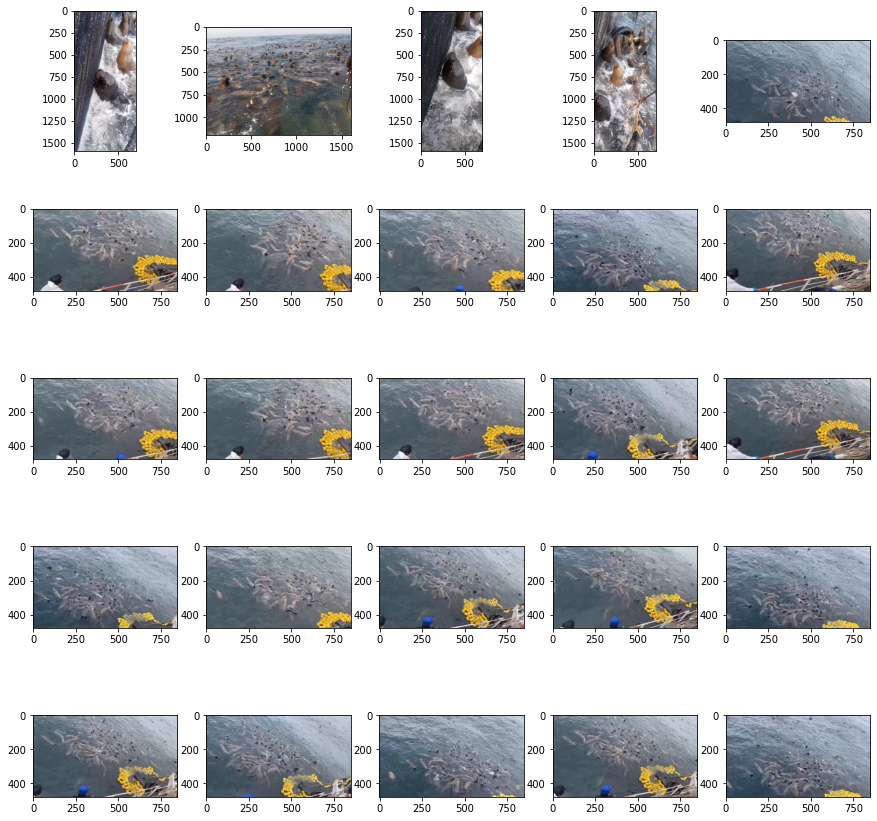

In [8]:
#Mostrar algunas imagenes con pyplot
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

carpeta = '/content/drive/MyDrive/train_mpreac_new/images/train'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

In [11]:
import os
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator, load_img, image, img_to_array


DG_folder='/content/drive/MyDrive/train_mpreac_new'
images_increased = 5

try:
    os.mkdir(DG_folder)
except:
    print("")
    
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)


data_path = "/content/drive/MyDrive/train_mpreac_new/images/train"
data_dir_list = os.listdir(data_path)


width_shape, height_shape = 224, 244

i=0
num_images=0
for image_file in data_dir_list:
    img_list=os.listdir(data_path)

    img_path = data_path + '/'+ image_file

    imge=load_img(img_path)
    
    imge=cv2.resize(image.img_to_array(imge), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
    x= imge/255
    x=np.expand_dims(x,axis=0)
    t=1
    for output_batch in train_datagen.flow(x,batch_size=1):
        a=image.img_to_array(output_batch[0])
        imagen=output_batch[0,:,:]*255
        imgfinal = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        cv2.imwrite(DG_folder+"/%i%i.jpg"%(i,t), imgfinal) 
        t+=1
        
        num_images+=1
        if t>images_increased:
            break
    i+=1
    
print("images generated",num_images)




images generated 4960


# Step 2: Assemble Our Dataset

In order to train our custom model, we need to assemble a dataset of representative images with bounding box annotations around the objects that we want to detect. And we need our dataset to be in YOLOv5 format.

In Roboflow, you can choose between two paths:

* Convert an existing dataset to YOLOv5 format. Roboflow supports over [30 formats object detection formats](https://roboflow.com/formats) for conversion.
* Upload raw images and annotate them in Roboflow with [Roboflow Annotate](https://docs.roboflow.com/annotate).

# Annotate

![](https://roboflow-darknet.s3.us-east-2.amazonaws.com/roboflow-annotate.gif)

# Version

![](https://roboflow-darknet.s3.us-east-2.amazonaws.com/robolfow-preprocessing.png)


In [ ]:
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="ultralytics")

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=ultralytics


In [ ]:
# set up environment
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [ ]:
#after following the link above, recieve python code with these fields filled in
#from roboflow import Roboflow
#rf = Roboflow(api_key="YOUR API KEY HERE")
#project = rf.workspace().project("YOUR PROJECT")
#dataset = project.version("YOUR VERSION").download("yolov5")

Extracting Dataset Version Zip to /content/datasets/American-Mushrooms-1 in yolov5pytorch:: 100%|██████████| 278/278 [00:00<00:00, 1046.33it/s]


# Step 3: Train Our Custom YOLOv5 model

Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** Our dataset locaiton is saved in the `dataset.location`
- **weights:** specify a path to weights to start transfer learning from. Here we choose the generic COCO pretrained checkpoint.
- **cache:** cache images for faster training

In [2]:
!python train.py --img 640 --batch 16 --epochs 250 --data /content/yolov5/data/lobpeldrivetraintrain.yaml --weights yolov5x.pt --cache

python3: can't open file 'train.py': [Errno 2] No such file or directory


# Evaluate Custom YOLOv5 Detector Performance
Training losses and performance metrics are saved to Tensorboard and also to a logfile.

If you are new to these metrics, the one you want to focus on is `mAP_0.5` - learn more about mean average precision [here](https://blog.roboflow.com/mean-average-precision/).

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 416 --conf 0.1 --source {dataset.location}/test/images

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/datasets/American-Mushrooms-1/test/images, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-471-g2993c3f torch 1.9.0+cu102 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 224 layers, 7056607 parameters, 0 gradients, 16.3 GFLOPs
image 1/5 /content/datasets/American-Mushrooms-1/test/images/chanterelle_02_jpg.rf.a75f69cbc359b824bb7ab938aae0f78c.jpg: 416x416 4 chanterelles, Done. (0.006s)
image 2/5 /content/datasets/American-Mushrooms-1/test/images/chanterelle_03_jpg.rf.846e06d86f791840504a794757a1d309.jpg: 416x416 2 chanterelles, Done. (0.006s)
image 3/5 /content/datasets/American-Mushroom

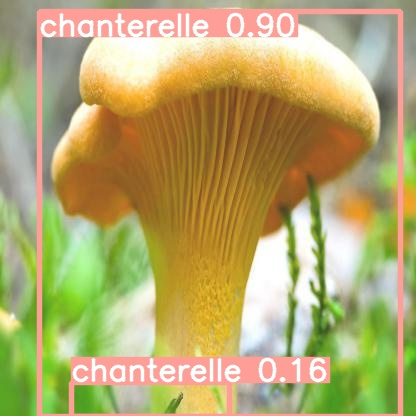

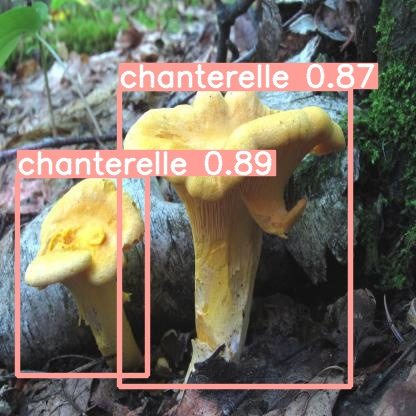

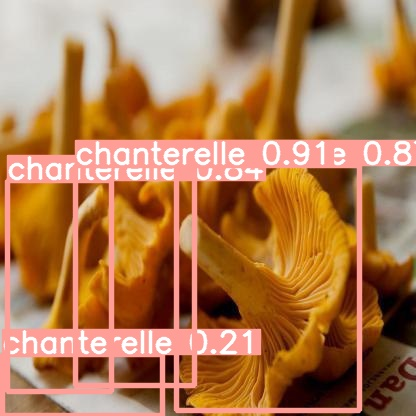

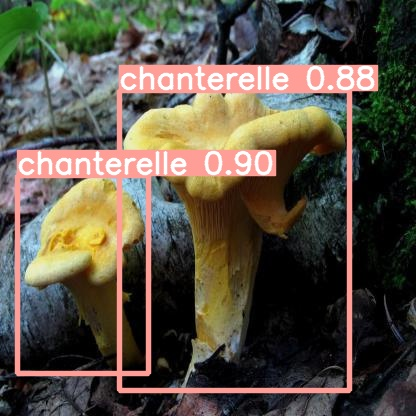

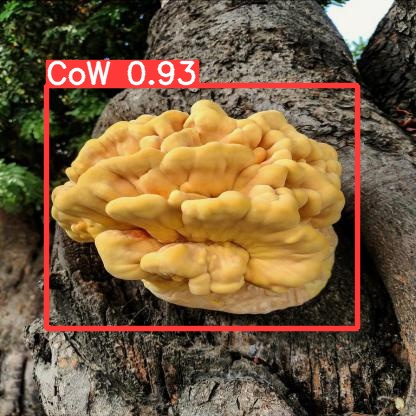

In [ ]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Conclusion and Next Steps

Congratulations! You've trained a custom YOLOv5 model to recognize your custom objects.

To improve you model's performance, we recommend first interating on your datasets coverage and quality. See this guide for [model performance improvement](https://github.com/ultralytics/yolov5/wiki/Tips-for-Best-Training-Results).

To deploy your model to an application, see this guide on [exporting your model to deployment destinations](https://github.com/ultralytics/yolov5/issues/251).

Once your model is in production, you will want to continually iterate and improve on your dataset and model via [active learning](https://blog.roboflow.com/what-is-active-learning/).

In [ ]:
#export your model's weights for future use
from google.colab import files
files.download('./runs/train/exp/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>